In [4]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as tf
import PIL
import random
import matplotlib.pyplot as plt
import albumentations as A

Алгоритм вычисления iou взял отсюда https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/

In [203]:
def compute_IOU(pred_mask, target_mask):
    numerator = torch.sum(torch.logical_and(target_mask==pred_mask, pred_mask==1))
    denominator = (
        torch.sum(torch.logical_and(target_mask == 1, pred_mask == 1)) + 
        torch.sum(torch.logical_and(target_mask == 0, pred_mask == 1)) +
        torch.sum(torch.logical_and(target_mask == 1, pred_mask == 0))
    )
    return numerator / denominator

In [204]:
class TargetTransform:
    def __init__(self, transform):
        self.transform = transform
                                         
    def __call__(self, segm):
        segm = self.transform(segm)
        return (segm == 0).type(torch.float)

transform = tf.Compose([tf.Resize((500, 500)), tf.ToTensor()])

target_transform = TargetTransform(transform)

In [205]:
# transforms = A.Compose([A.Resize(500, 500, interpolation=cv2.INTER_NEAREST)])


train_dataset = VOCSegmentation(".",
                                year="2012",
                                image_set="train",
                                download=False,
                                transform=transform,
                                target_transform=target_transform)

val_dataset = VOCSegmentation(".",
                             year="2012",
                             image_set="val",
                             download=False,
                             transform=transform,
                             target_transform=target_transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

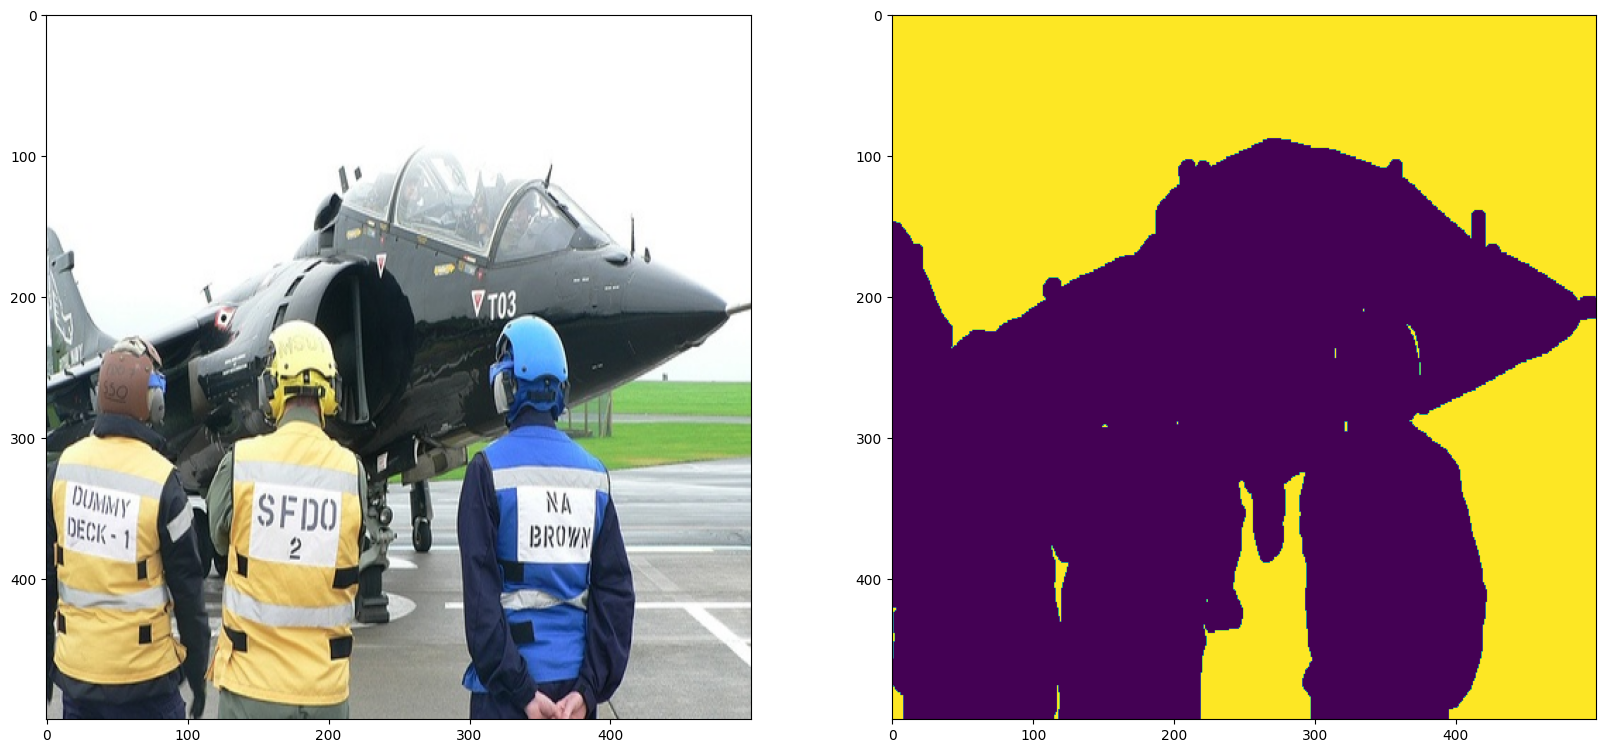

In [206]:
image, mask = train_dataset[14]

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(15)
f.set_figwidth(20)
ax1.imshow(image.permute(1, 2, 0))
ax2.imshow(mask.permute(1, 2, 0))
plt.show()

In [207]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from PIL import Image
import cv2

# class VOCDataset(torch.utils.data.Dataset):
#     def __init__(self, image_set, image_size=(500, 500), transform=None, dataset_path=".", year="2012"):
#         self._dataset = VOCSegmentation(dataset_path,
#                                        year=year,
#                                        image_set=image_set,
#                                        download=False)
#         self.transform = transform
#         self.mean = [0.485, 0.456, 0.406]
#         self.std = [0.229, 0.224, 0.225]
#         self.image_size = image_size
    
#     def __len__(self):
#         return len(self._dataset)
    
#     def __getitem__(self, idx):
#         image, mask = self._dataset[idx]
#         image = np.asarray(image)
#         mask = np.array(mask)
        
#         mask[mask > 0] = 1
        
#         if self.transform:
#             aug = self.transform(image=image, mask=mask)
#             image = Image.fromarray(aug["image"])
#             mask = aug["mask"]
        

#         t = transforms.Compose([transforms.ToTensor(),
#                                     transforms.Normalize(self.mean, self.std)])
                        
#         image = t(image)
#         mask = torch.from_numpy(mask).float()
        
        
#         return image, mask

def collate_fn(batch):
    return tuple(zip(*batch))



# transform = A.Compose([A.Resize(500, 500, interpolation=cv2.INTER_NEAREST)])



# train_data_loader = torch.utils.data.DataLoader(train_dataset,
#                                                 batch_size=1,
#                                                 shuffle=True,
#                                                 collate_fn=collate_fn)

# test_data_loader = torch.utils.data.DataLoader(val_dataset,
#                                                 batch_size=1,
#                                                 shuffle=False,
#                                                 collate_fn=collate_fn)

In [208]:
from torchvision.models.segmentation import fcn_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"

model = fcn_resnet50(num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [210]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F


def dice_loss(pred, gt, epsilon=1):
        pred = F.sigmoid(pred.view(-1))
        gt = gt.view(-1)
        
        dice = (gt * pred).sum() + epsilon
        dice = dice / (pred.sum() + gt.sum() + epsilon)
        
        dice = 1 - dice
        
        return dice

class MultiLoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(MultiLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = dice_loss
        self.alpha = alpha
    
    def forward(self, pred, gt):
        dice_loss_comp = self.dice(pred, gt)
        bce_loss_comp = self.bce(pred, gt)
        
        return bce_loss_comp + (1 - self.alpha) * dice_loss_comp

    
def train_loop(model, optimizer, data_loader, loss_fn):
    model.train()
    run_loss = 0
    obj_cntr = 0
    for i, (image, mask) in enumerate(data_loader):
        optimizer.zero_grad()
#         c, h, w = image.size()
#         image = image.view(-1, c, h, w)
        image = image.to(device)
        mask = mask.to(device)
        output = model(image)['out']
        loss = loss_fn(output, mask)
        obj_cntr += len(image)
        run_loss += loss.item()
        loss.backward()
        optimizer.step()
    return run_loss / obj_cntr


def val_loop(model, data_loader, loss_fn):
    model.eval()
    run_loss = 0
    obj_cntr = 0
    for i, (image, mask) in enumerate(data_loader):
        image = image.to(device)
        mask = mask.to(device)
        
        with torch.no_grad():
            output = model(image)['out']
        
        loss = loss_fn(output, mask)
        obj_cntr += len(image)
        run_loss += loss.item()
    
    return run_loss / obj_cntr

In [211]:
loss_fn = MultiLoss(alpha=0.1)
epochs = 10
for epochs in tqdm(range(epochs)):
    train_loss = train_loop(model, optimizer, train_data_loader, loss_fn)
    val_loss = val_loop(model, val_data_loader, loss_fn)
    print(f"train_loss: {train_loss}")

 10%|█         | 1/10 [04:28<40:20, 268.92s/it]

train_loss: 0.9941807240654862


 20%|██        | 2/10 [08:58<35:55, 269.46s/it]

train_loss: 0.8313483304746164


 30%|███       | 3/10 [13:28<31:26, 269.51s/it]

train_loss: 0.7167074259350209


 40%|████      | 4/10 [17:58<26:57, 269.58s/it]

train_loss: 0.6358173874313714


 50%|█████     | 5/10 [22:27<22:27, 269.47s/it]

train_loss: 0.5929445228819313


 60%|██████    | 6/10 [26:56<17:57, 269.38s/it]

train_loss: 0.5668521911068692


 70%|███████   | 7/10 [31:25<13:28, 269.34s/it]

train_loss: 0.547391096221619


 80%|████████  | 8/10 [35:54<08:58, 269.28s/it]

train_loss: 0.5358868350218879


 90%|█████████ | 9/10 [40:24<04:29, 269.28s/it]

train_loss: 0.5263680971222497


100%|██████████| 10/10 [44:53<00:00, 269.36s/it]

train_loss: 0.518618304445281


In [212]:
miou = 0
obj_cntr = 0
for i, (image, mask) in enumerate(val_data_loader):
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        output = model(image)
    
    output = output['out'].detach()
    output = output.sigmoid()
    output = (output > 0.5).to(torch.long)
    
    iou = compute_IOU(output[0], mask[0])
    miou += iou
#     print(iou)
    obj_cntr += len(image)
    if i == 100:
        print(f"iter: {i}")

print(miou / obj_cntr)

iter: 100
tensor(0.8332, device='cuda:0')


**Используем предобученную модель**

In [213]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

model = fcn_resnet50(num_classes=21, weights="COCO_WITH_VOC_LABELS_V1")
model


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 86.4MB/s] 


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Необходимо заменить классицикационную голову, так как исходные веса предназначены для 21 класса

In [214]:
model.classifier = nn.Sequential(
    nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))    
)

model.aux_classifier = nn.Sequential(
    nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [215]:
loss_fn = MultiLoss(alpha=0.1)
epochs = 10
for epochs in tqdm(range(epochs)):
    train_loss = train_loop(model, optimizer, train_data_loader, loss_fn)
    val_loss = val_loop(model, val_data_loader, loss_fn)
    print(f"train_loss: {train_loss}")

 10%|█         | 1/10 [04:33<41:02, 273.64s/it]

train_loss: 0.8741905131870932


 20%|██        | 2/10 [09:07<36:29, 273.70s/it]

train_loss: 0.722412534424516


 30%|███       | 3/10 [13:41<31:56, 273.80s/it]

train_loss: 0.6271633039651021


 40%|████      | 4/10 [18:15<27:24, 274.03s/it]

train_loss: 0.5767128702477028


 50%|█████     | 5/10 [22:49<22:49, 273.99s/it]

train_loss: 0.5515406759750974


 60%|██████    | 6/10 [27:22<18:14, 273.74s/it]

train_loss: 0.5357459312294676


 70%|███████   | 7/10 [31:56<13:40, 273.64s/it]

train_loss: 0.5219909665810931


 80%|████████  | 8/10 [36:30<09:07, 273.71s/it]

train_loss: 0.5115222233077867


 90%|█████████ | 9/10 [41:03<04:33, 273.72s/it]

train_loss: 0.5042752654500346


100%|██████████| 10/10 [45:37<00:00, 273.76s/it]

train_loss: 0.49896548319954037


In [216]:
miou = 0
obj_cntr = 0
for i, (image, mask) in enumerate(val_data_loader):
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        output = model(image)
    
    output = output['out'].detach()
    output = output.sigmoid()
    output = (output > 0.5).to(torch.long)
    
    iou = compute_IOU(output[0], mask[0])
    miou += iou
#     print(iou)
    obj_cntr += len(image)
    if i == 100:
        print(f"iter: {i}")

print(miou / obj_cntr)

iter: 100
tensor(0.8694, device='cuda:0')


Попробуем обучить не предобученную модель с использование BCEWithLogitsLoss, а не написанного мультилосса

In [217]:
model = fcn_resnet50(num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
loss = torch.nn.BCEWithLogitsLoss()

model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [218]:
epochs = 10
for epochs in tqdm(range(epochs)):
    train_loss = train_loop(model, optimizer, train_data_loader, loss)
    val_loss = val_loop(model, val_data_loader, loss)
    print(f"train_loss: {train_loss}")

 10%|█         | 1/10 [04:29<40:23, 269.28s/it]

train_loss: 0.43670185274174794


 20%|██        | 2/10 [08:58<35:55, 269.44s/it]

train_loss: 0.31168243933285844


 30%|███       | 3/10 [13:28<31:25, 269.39s/it]

train_loss: 0.21056175676729183


 40%|████      | 4/10 [17:57<26:55, 269.30s/it]

train_loss: 0.14731180260996105


 50%|█████     | 5/10 [22:26<22:25, 269.19s/it]

train_loss: 0.11172551130799607


 60%|██████    | 6/10 [26:55<17:56, 269.08s/it]

train_loss: 0.09188887620054674


 70%|███████   | 7/10 [31:23<13:26, 268.77s/it]

train_loss: 0.0769029652643847


 80%|████████  | 8/10 [35:51<08:56, 268.47s/it]

train_loss: 0.06391161555154605


 90%|█████████ | 9/10 [40:19<04:28, 268.28s/it]

train_loss: 0.057082523220305235


100%|██████████| 10/10 [44:46<00:00, 268.68s/it]

train_loss: 0.052420824976088326


In [219]:
miou = 0
obj_cntr = 0
for i, (image, mask) in enumerate(val_data_loader):
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        output = model(image)
    
    output = output['out'].detach()
    output = output.sigmoid()
    output = (output > 0.5).to(torch.long)
    
    iou = compute_IOU(output[0], mask[0])
    miou += iou
#     print(iou)
    obj_cntr += len(image)
    if i == 100:
        print(f"iter: {i}")

print(miou / obj_cntr)

iter: 100
tensor(0.8201, device='cuda:0')


**Добавим аугментаций к нашей исходной модели**

In [220]:
augm_transform = tf.Compose([
     tf.Resize((500, 500)),
     tf.ToTensor(),
     tf.ColorJitter(0.2, 0.2),
     tf.GaussianBlur(5),
     tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

augm_target_transform = TargetTransform(transform)

train_dataset = VOCSegmentation(".",
                                year="2012",
                                image_set="train",
                                download=False,
                                transform=augm_transform,
                                target_transform=augm_target_transform)

val_dataset = VOCSegmentation(".",
                             year="2012",
                             image_set="val",
                             download=False,
                             transform=augm_transform,
                             target_transform=target_transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [221]:
from torchvision.models.segmentation import fcn_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"
model = fcn_resnet50(num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

model.to(device)

loss_fn = MultiLoss(alpha=0.1)
epochs = 10
for epochs in range(epochs):
    train_loss = train_loop(model, optimizer, train_data_loader, loss_fn)
    print(train_loss)

0.9902165031742528
0.8528524133595613
0.7508103134202175
0.6818710958045688
0.6327539850535289
0.5971559125502579
0.5730256154685398
0.5571488418458589
0.5424706316629394
0.5344745961979764


In [222]:
miou = 0
obj_cntr = 0
for i, (image, mask) in enumerate(val_data_loader):
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        output = model(image)
    
    output = output['out'].detach()
    output = output.sigmoid()
    output = (output > 0.5).to(torch.long)
    
    iou = compute_IOU(output[0], mask[0])
    miou += iou
#     print(iou)
    obj_cntr += len(image)
    if i == 100:
        print(f"iter: {i}")

print(miou / obj_cntr)

iter: 100
tensor(0.8253, device='cuda:0')


In [162]:
a = torch.Tensor([[[[1, 2, 3], [0, 1, 1]]]]).softmax(dim=3)
print(a)
print(a.argmax(dim=3) == 0)

tensor([[[[0.0900, 0.2447, 0.6652],
          [0.1554, 0.4223, 0.4223]]]])
tensor([[[False, False]]])


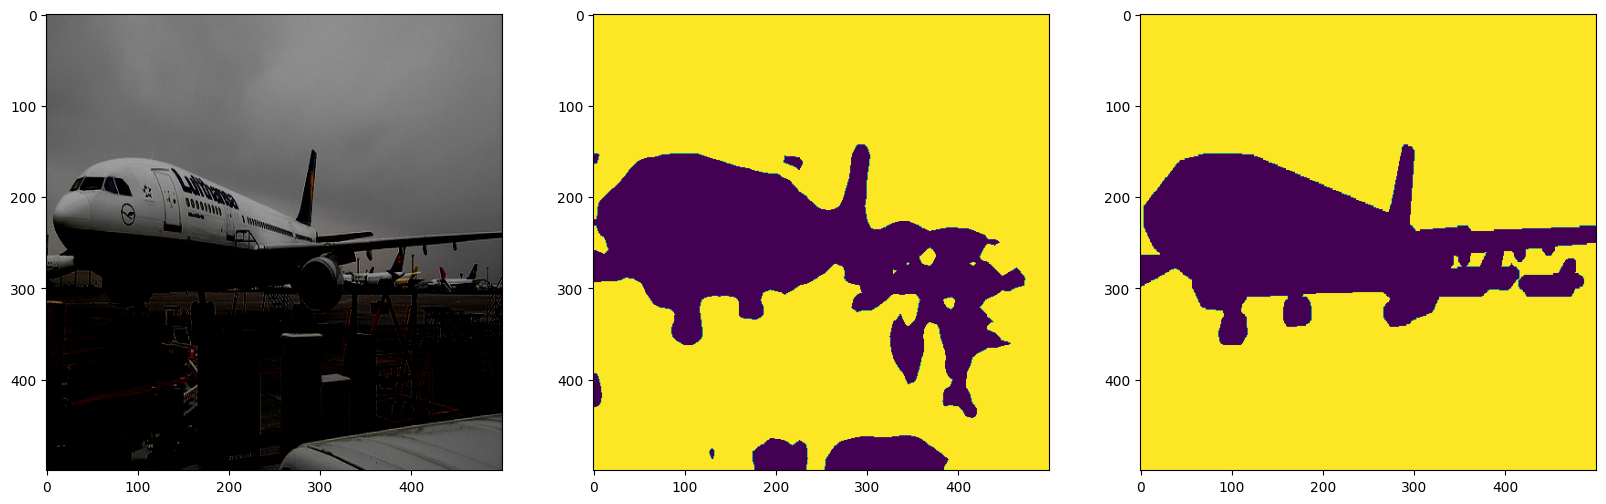

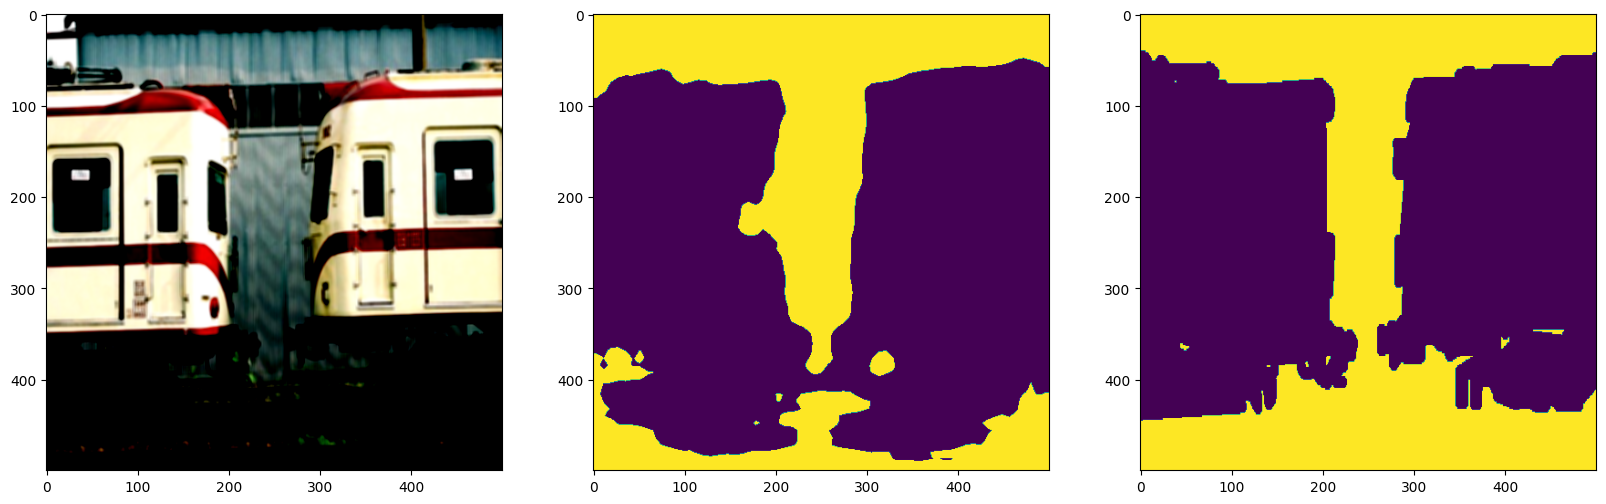

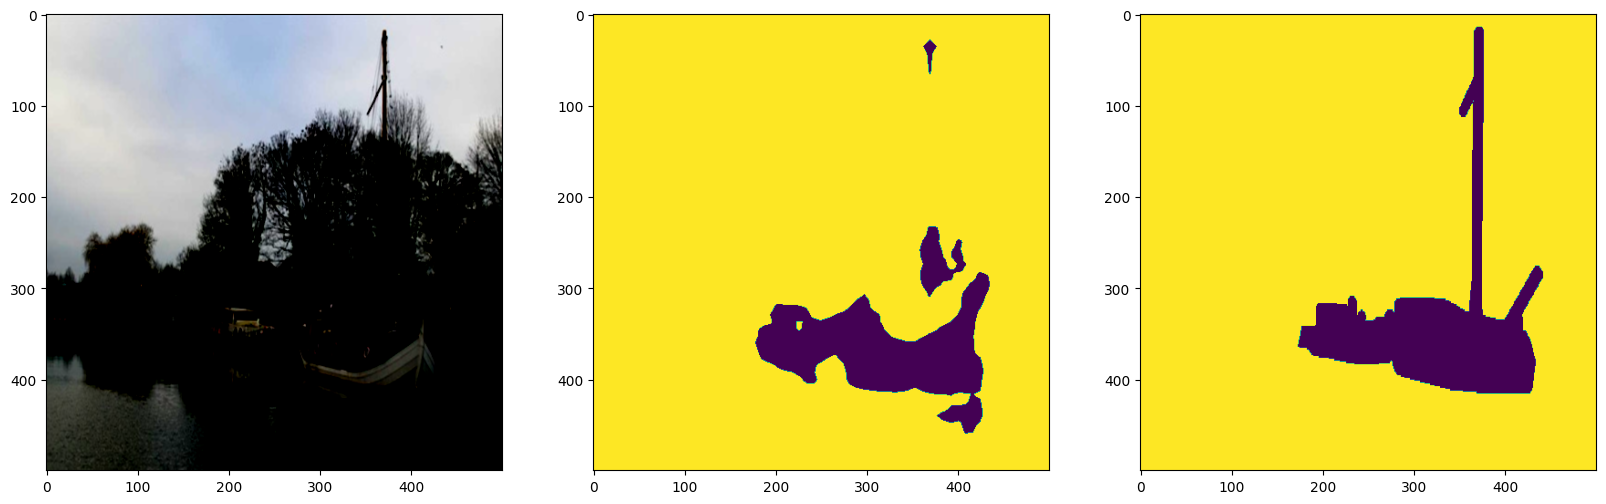

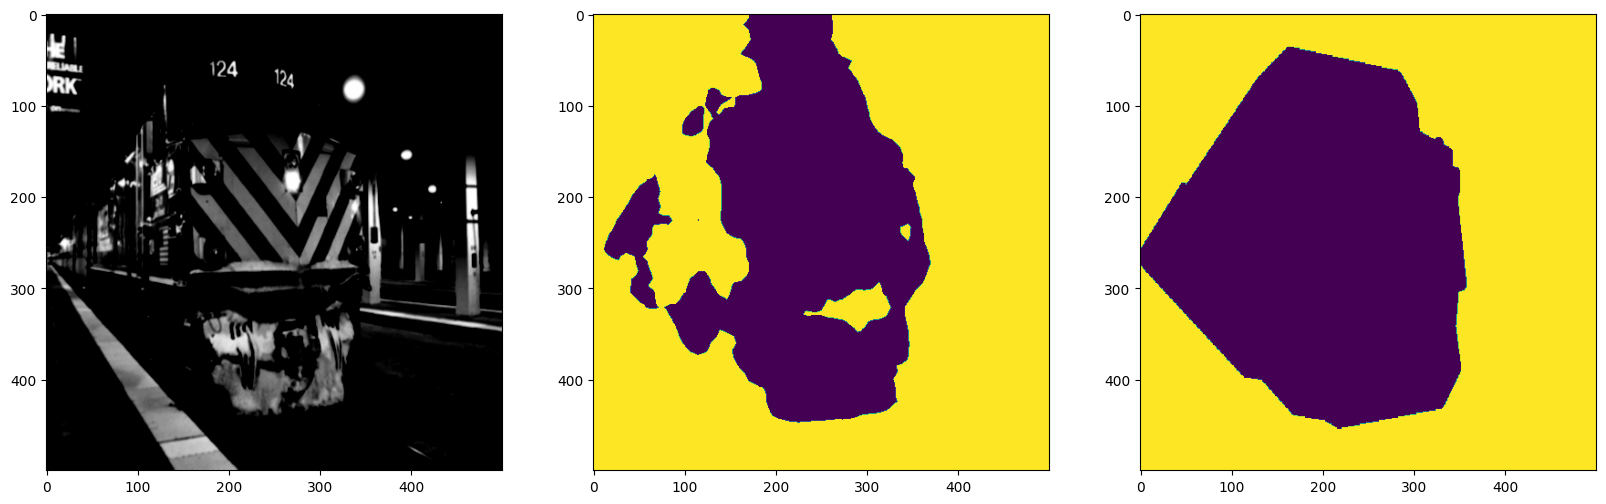

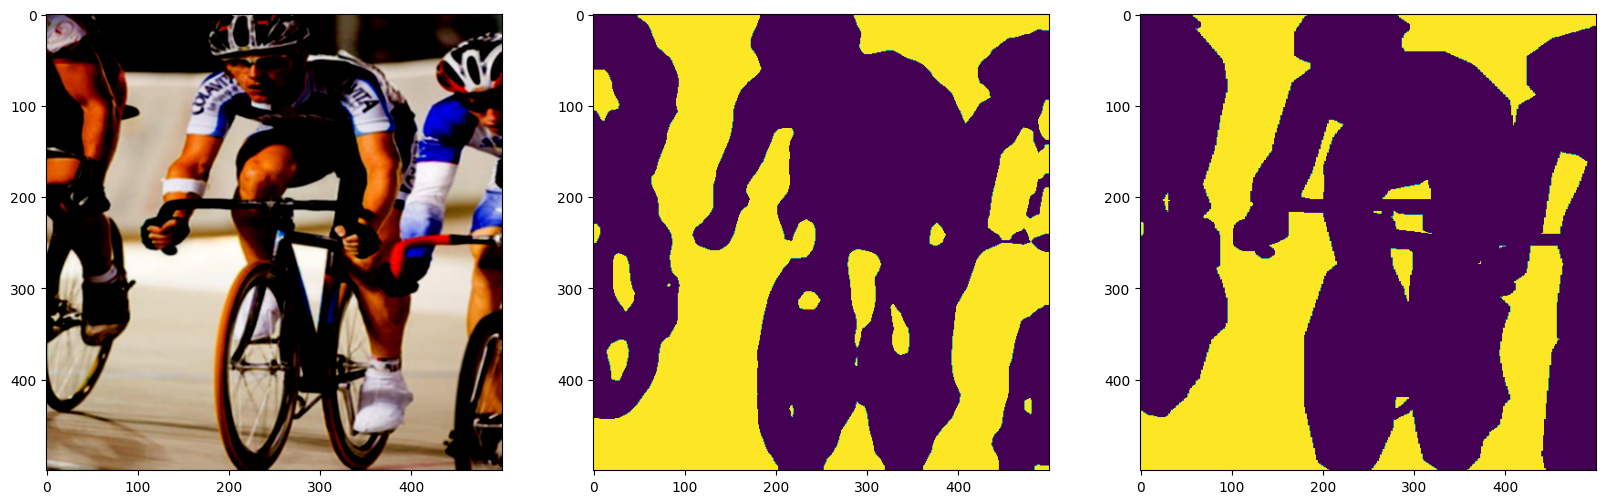

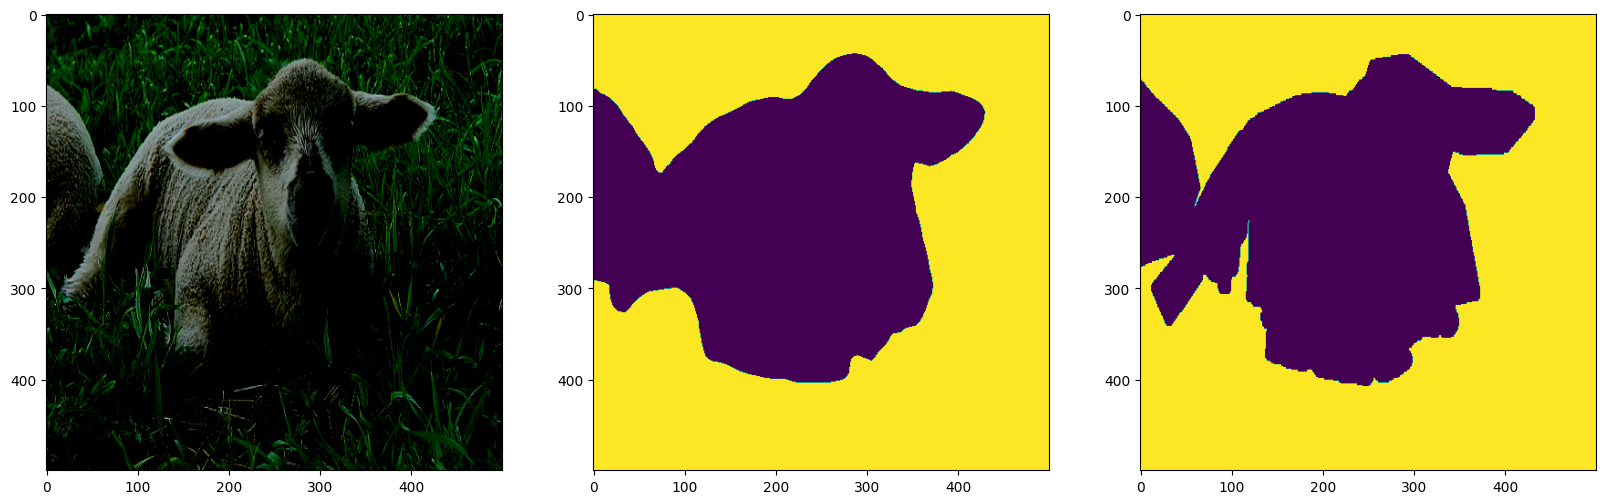

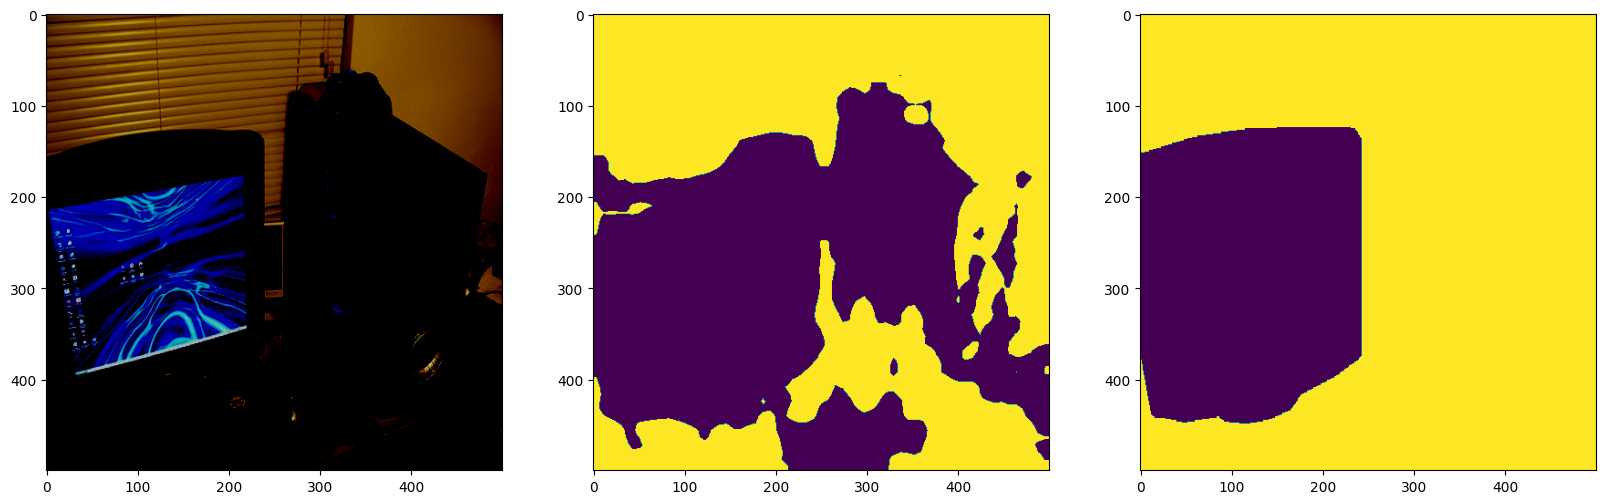

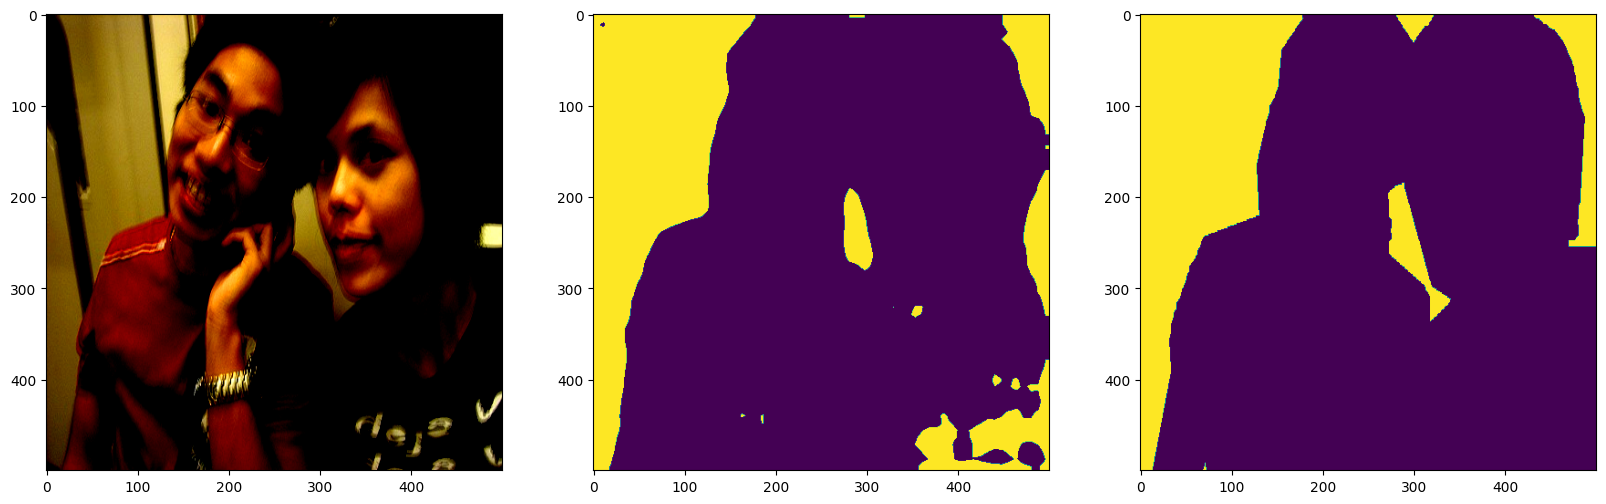

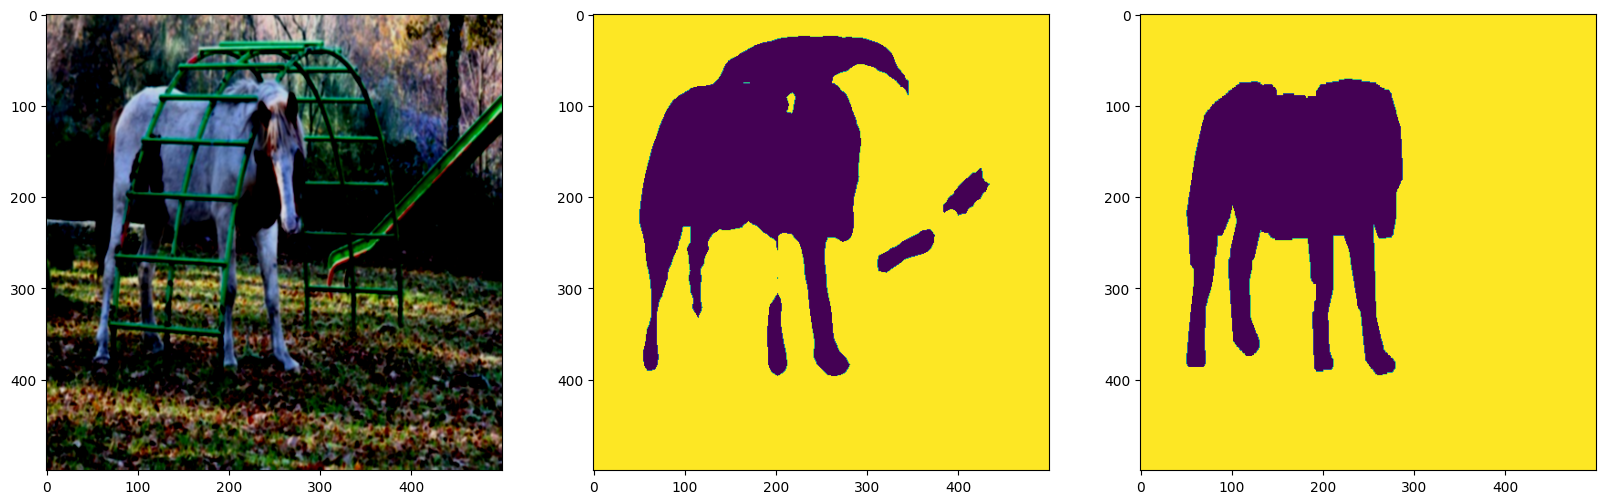

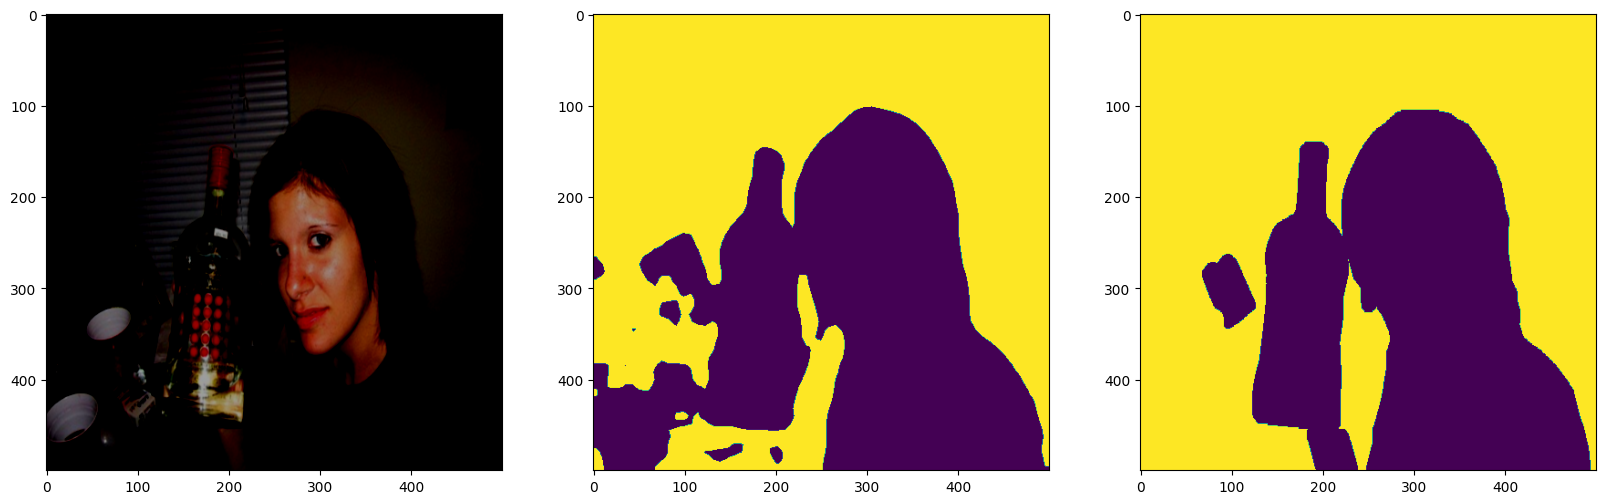

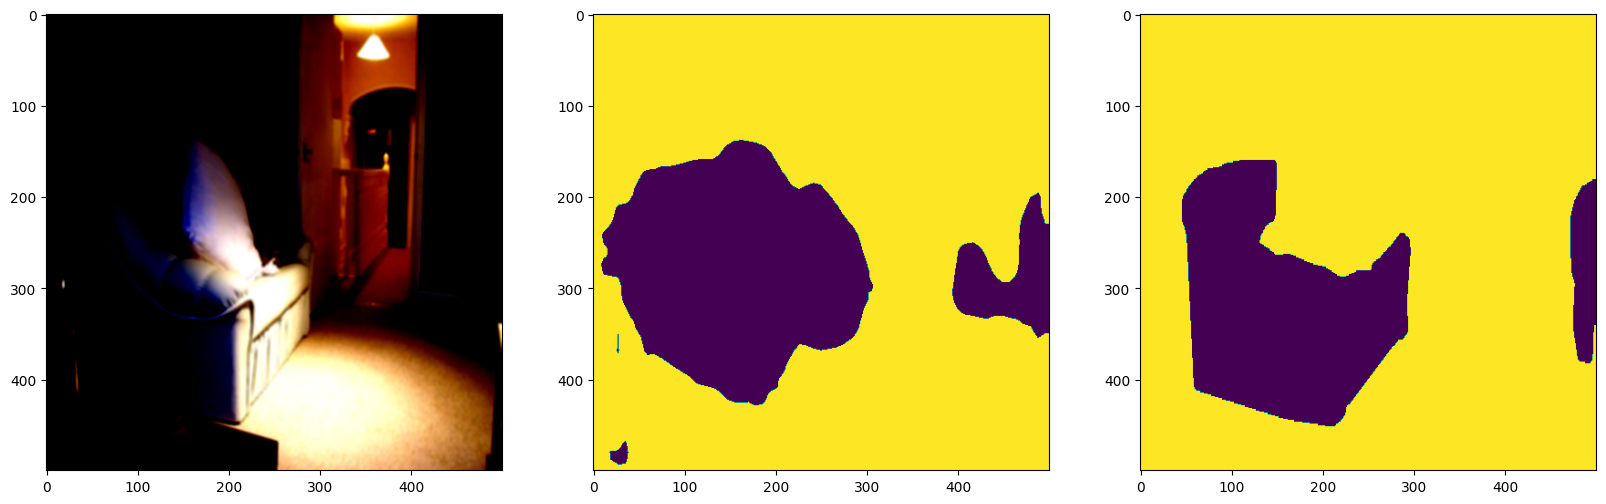

In [223]:
for i, (image, mask) in enumerate(val_data_loader):
    model.eval()
    image = image.to(device)
    
    with torch.no_grad():
        output = model(image)
    
    output = output['out'].detach().to('cpu')
    output = output.sigmoid()
    output = (output > 0.5).to(torch.long)
    
    image = image.to('cpu')
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figheight(15)
    f.set_figwidth(20)
    ax1.imshow(image[0].permute(1, 2, 0))
    ax2.imshow(output[0].permute(1, 2, 0))
    ax3.imshow(mask[0].permute(1, 2, 0))
#     plt.show()
    
    if i == 10:
        break

На выведенных картинках можно заметить, что модель плохо распознает изображения, при плохом освещении, либо когда очень темно. Возможно стоило сделать больше агументаций для затемнение некоторых областей и на этом обучить модель. Также есть проблемы, когда основной объект закрыт другим.

In [224]:
miou = 0
obj_cntr = 0
for i, (image, mask) in enumerate(val_data_loader):
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        output = model(image)
    
    output = output['out'].detach()
    output = output.sigmoid()
    output = (output > 0.5).to(torch.long)
    
    iou = compute_IOU(output[0], mask[0])
    miou += iou
#     print(iou)
    obj_cntr += len(image)
    if i == 100:
        print(f"iter: {i}")

print(miou / obj_cntr)

iter: 100
tensor(0.8240, device='cuda:0')


**Выводы**

Предобученная модель обучалась быстрее остальных. Также у предобученной модели получилось самое высокое значение метрики MIOU. Аугментации не дали прироста в скорости обучения и результаты модели без предобученных весов показали не очень хороший результат. Картинки на которых объект засвечен, пересвечен, закрыт другим объектом распознаются крайне плохо.